<h2> CNN for Music Genre Classification </h2>

In [86]:
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

In [52]:
# Define transformations
data_transform = transforms.Compose([
    transforms.Resize((216, 144)),  # Resize images to a standard size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet means and stds
])

Load the data

In [53]:
dataset = datasets.ImageFolder(root='./Data/images_original', transform=data_transform)

Visualize the first mel-spectrogram image in each genre

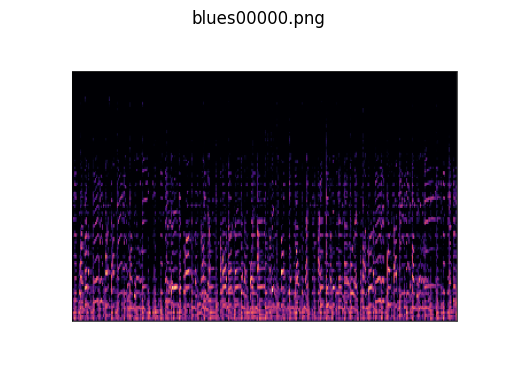

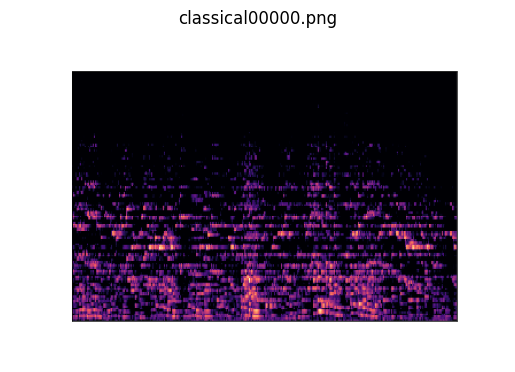

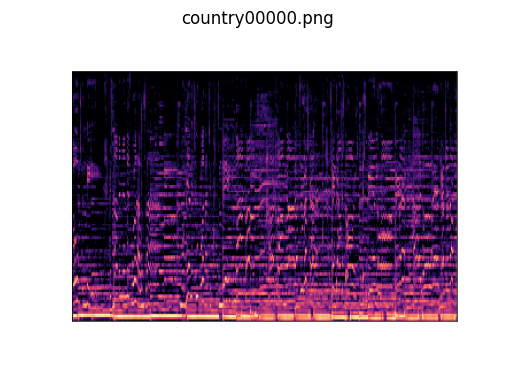

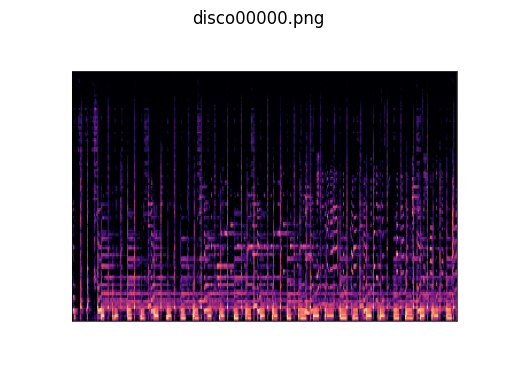

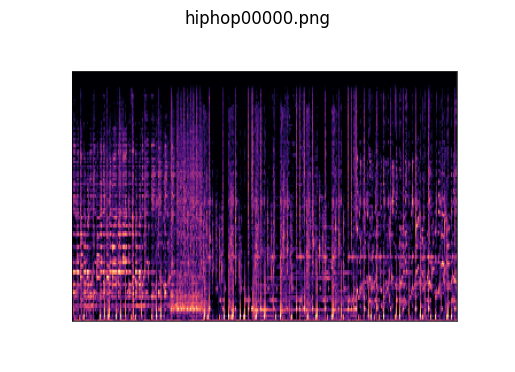

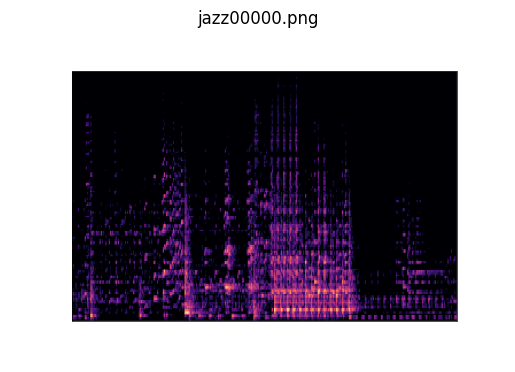

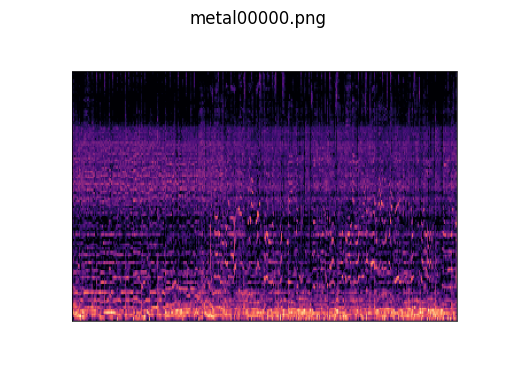

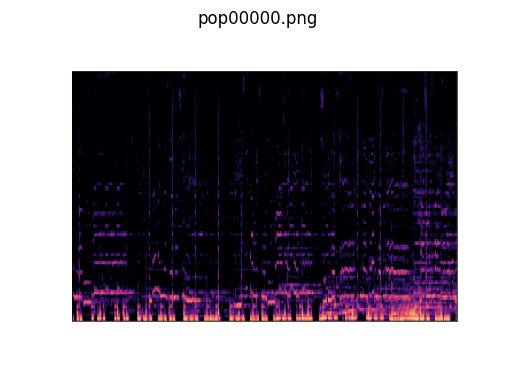

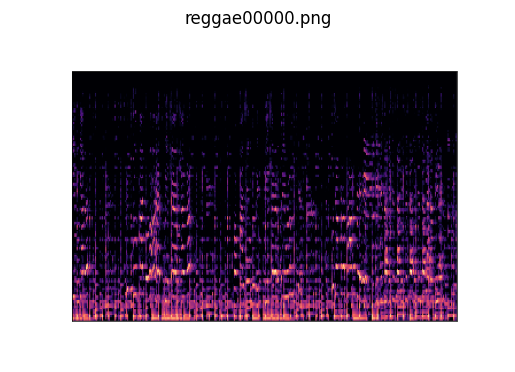

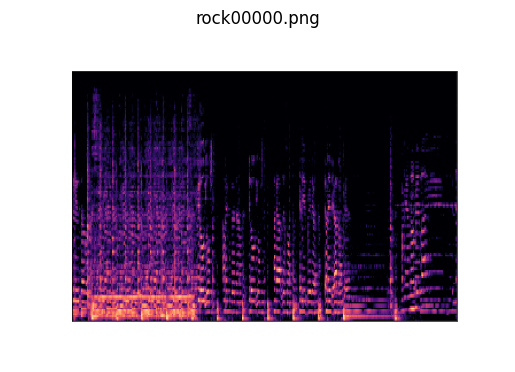

In [85]:
image_dir = './Data/images_original'

def show_image(image_path):
    img = Image.open(image_path)
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(os.path.basename(image_path))
    ax.axis('off')
    plt.show()

# Collect image file paths
image_paths = []
for genre in os.listdir(image_dir):
	genre_dir = os.path.join(image_dir, genre)
	if os.path.isdir(genre_dir):
		for image_name in os.listdir(genre_dir):
			image_path = os.path.join(genre_dir, image_name)
			if os.path.isfile(image_path):
				image_paths.append(image_path)
				break

# Display the first mel-spectrogram for each genre
for i in range(10):
    show_image(image_paths[i])

Split into train and validation sets

In [54]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Create dataloader instances

In [55]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [56]:
class MusicGenreCNN(nn.Module):
	def __init__(self):
		super(MusicGenreCNN, self).__init__()
		self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
		self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
		self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
		self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
		self.dropout = nn.Dropout(p=0.3)
		self.fc1 = nn.Linear(128 * 27 * 18, 512)
		self.fc2 = nn.Linear(512, 128)
		self.fc3 = nn.Linear(128, 10)

	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = self.pool(F.relu(self.conv3(x)))
		x = x.view(-1, 128 * 27 * 18)
		x = F.relu(self.fc1(x))
		x = self.dropout(x)
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		return x

Define the model

In [57]:
# Initialize the model
model = MusicGenreCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Define scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Train the model

In [59]:
best_val_loss = float('inf')
num_epochs = 20
for epoch in range(num_epochs):
	model.train()
	running_loss = 0.0
	for images, labels in train_loader:
		optimizer.zero_grad()
		outputs = model(images)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()
		running_loss += loss.item() * images.size(0)

	epoch_loss = running_loss / len(train_loader.dataset)
	print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

	# Validation
	model.eval()
	val_loss = 0.0
	correct = 0
	total = 0
	for images, labels in val_loader:
		outputs = model(images)
		loss = criterion(outputs, labels)
		val_loss += loss.item() * images.size(0)
		_, predicted = torch.max(outputs, 1)
		total += labels.size(0)
		correct += (predicted == labels).sum().item()

	print(f'Validation Loss: {val_loss / len(val_loader.dataset):.4f}, Accuracy: {correct / total:.4f}')

	if val_loss < best_val_loss:
		best_val_loss = val_loss
		torch.save(model.state_dict(), 'Best_DL_Models/Best_Image_Model.pth')

	scheduler.step()

Epoch 1/20, Loss: 2.3533
Validation Loss: 2.1715, Accuracy: 0.2100
Epoch 2/20, Loss: 2.1168
Validation Loss: 2.0686, Accuracy: 0.1700
Epoch 3/20, Loss: 2.0045
Validation Loss: 1.8533, Accuracy: 0.3600
Epoch 4/20, Loss: 1.8202
Validation Loss: 1.7279, Accuracy: 0.3900
Epoch 5/20, Loss: 1.6156
Validation Loss: 1.5680, Accuracy: 0.4500
Epoch 6/20, Loss: 1.4712
Validation Loss: 1.4942, Accuracy: 0.5050
Epoch 7/20, Loss: 1.3433
Validation Loss: 1.5013, Accuracy: 0.4800
Epoch 8/20, Loss: 1.1236
Validation Loss: 1.3872, Accuracy: 0.5450
Epoch 9/20, Loss: 1.0498
Validation Loss: 1.3695, Accuracy: 0.5550
Epoch 10/20, Loss: 0.9812
Validation Loss: 1.3241, Accuracy: 0.5650
Epoch 11/20, Loss: 0.9559
Validation Loss: 1.3006, Accuracy: 0.5650
Epoch 12/20, Loss: 0.9139
Validation Loss: 1.3145, Accuracy: 0.5700
Epoch 13/20, Loss: 0.9059
Validation Loss: 1.3451, Accuracy: 0.5550
Epoch 14/20, Loss: 0.8478
Validation Loss: 1.2746, Accuracy: 0.6000
Epoch 15/20, Loss: 0.7944
Validation Loss: 1.2598, Accura

Evaluate model

              precision    recall  f1-score   support

           0       0.60      0.55      0.57        22
           1       0.83      0.79      0.81        19
           2       0.55      0.61      0.58        18
           3       0.52      0.58      0.55        19
           4       0.42      0.67      0.51        15
           5       0.57      0.63      0.60        19
           6       0.69      0.69      0.69        16
           7       0.76      0.68      0.72        28
           8       0.72      0.59      0.65        22
           9       0.65      0.50      0.56        22

    accuracy                           0.62       200
   macro avg       0.63      0.63      0.62       200
weighted avg       0.64      0.62      0.63       200



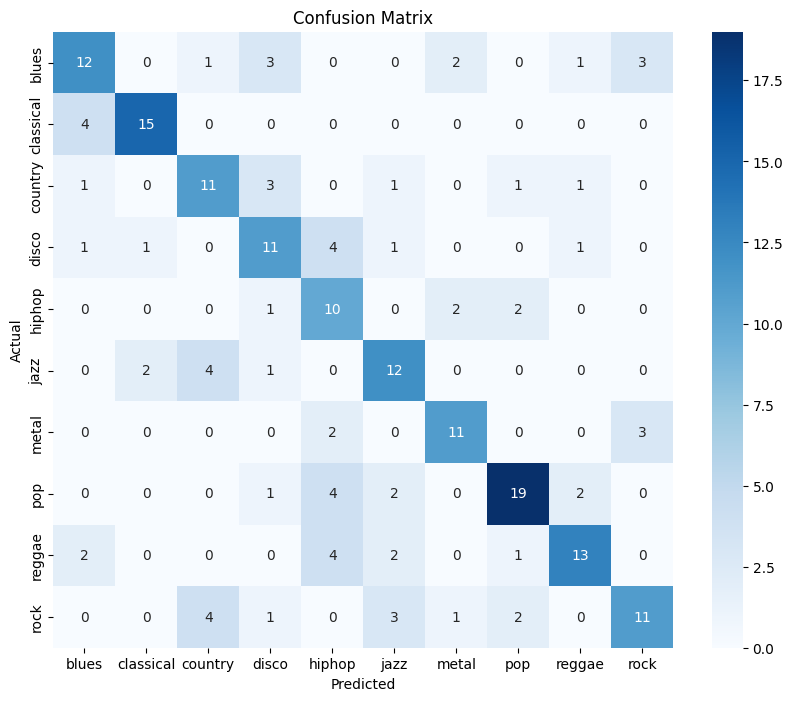

In [60]:
model.load_state_dict(torch.load('Best_DL_Models/Best_Image_Model.pth'))

# Classification report
model.eval()
y_true = []
y_pred = []
for images, labels in val_loader:
	outputs = model(images)
	_, predicted = torch.max(outputs, 1)
	y_true += labels.tolist()
	y_pred += predicted.tolist()

print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Apply transfer learning on pre-trained model

In [89]:
# Load pre-trained ResNet model
model_pretrained = models.resnet18(pretrained=True)

# Replace the last fully connected layer
num_ftrs = model_pretrained.fc.in_features
model_pretrained.fc = nn.Linear(num_ftrs, 10)

# Transfer the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_pretrained = model_pretrained.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained.parameters(), lr=0.001, weight_decay=0.0001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 20
best_val_loss = float('inf')

for epoch in range(num_epochs):
	model_pretrained.train()
	running_loss = 0.0
	for images, labels in train_loader:
		images, labels = images.to(device), labels.to(device)
		optimizer.zero_grad()
		outputs = model_pretrained(images)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()
		running_loss += loss.item() * images.size(0)

	epoch_loss = running_loss / len(train_loader.dataset)
	print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

	# Validation
	model_pretrained.eval()
	val_loss = 0.0
	correct = 0
	total = 0
	with torch.no_grad():
		for images, labels in val_loader:
			images, labels = images.to(device), labels.to(device)
			outputs = model_pretrained(images)
			loss = criterion(outputs, labels)
			val_loss += loss.item() * images.size(0)
			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()

	val_loss = val_loss / len(val_loader.dataset)
	accuracy = correct / total
	print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

	if val_loss < best_val_loss:
		best_val_loss = val_loss
		# Check if model directory exists, if not create it
		if not os.path.exists('Best_DL_Models'):
			os.makedirs('Best_DL_Models')

		torch.save(model_pretrained.state_dict(), 'Best_DL_Models/Best_Transfer_Model.pth')

	scheduler.step()

c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Loss: 1.5527
Validation Loss: 4.8933, Accuracy: 0.2550
Epoch 2/20, Loss: 1.0553
Validation Loss: 2.2384, Accuracy: 0.4150
Epoch 3/20, Loss: 0.8237
Validation Loss: 2.2546, Accuracy: 0.4200
Epoch 4/20, Loss: 0.6376
Validation Loss: 3.5401, Accuracy: 0.3600
Epoch 5/20, Loss: 0.5622
Validation Loss: 1.6397, Accuracy: 0.5500
Epoch 6/20, Loss: 0.4149
Validation Loss: 2.4541, Accuracy: 0.4550
Epoch 7/20, Loss: 0.3643
Validation Loss: 1.5549, Accuracy: 0.6150
Epoch 8/20, Loss: 0.1558
Validation Loss: 0.9358, Accuracy: 0.7400
Epoch 9/20, Loss: 0.0717
Validation Loss: 0.9248, Accuracy: 0.7550
Epoch 10/20, Loss: 0.0373
Validation Loss: 0.8840, Accuracy: 0.7500
Epoch 11/20, Loss: 0.0322
Validation Loss: 0.9165, Accuracy: 0.7400
Epoch 12/20, Loss: 0.0353
Validation Loss: 0.8898, Accuracy: 0.7450
Epoch 13/20, Loss: 0.0207
Validation Loss: 0.9050, Accuracy: 0.7350
Epoch 14/20, Loss: 0.0207
Validation Loss: 0.9096, Accuracy: 0.7500
Epoch 15/20, Loss: 0.0166
Validation Loss: 0.9048, Accura

              precision    recall  f1-score   support

       blues       1.00      0.95      0.98        22
   classical       1.00      1.00      1.00        19
     country       0.85      0.94      0.89        18
       disco       0.90      1.00      0.95        19
      hiphop       1.00      1.00      1.00        15
        jazz       0.95      1.00      0.97        19
       metal       0.94      1.00      0.97        16
         pop       0.96      0.93      0.95        28
      reggae       1.00      0.95      0.98        22
        rock       1.00      0.86      0.93        22

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



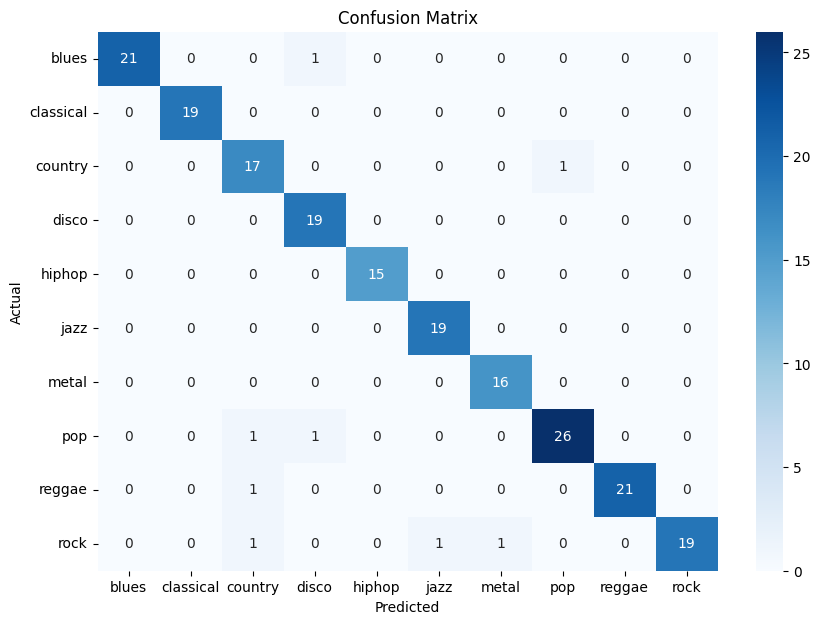

In [90]:
# Load and evaluate the best pre-trained model on the validation set
model_pretrained = models.resnet18()
num_ftrs = model_pretrained.fc.in_features
model_pretrained.fc = nn.Linear(num_ftrs, 10)
model_pretrained.load_state_dict(torch.load('Best_DL_Models/model_pretrained.pth'))
model_pretrained = model_pretrained.to(device)

model_pretrained.eval()
all_preds = []
all_labels = []

with torch.no_grad():
	for images, labels in val_loader:
		images, labels = images.to(device), labels.to(device)
		outputs = model_pretrained(images)
		_, predicted = torch.max(outputs, 1)
		all_preds.extend(predicted.cpu().numpy())
		all_labels.extend(labels.cpu().numpy())

# Generate classification report
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


              precision    recall  f1-score   support

       blues       0.72      0.59      0.65        22
   classical       0.86      0.95      0.90        19
     country       0.60      0.50      0.55        18
       disco       0.68      0.68      0.68        19
      hiphop       0.83      1.00      0.91        15
        jazz       0.67      0.95      0.78        19
       metal       0.93      0.88      0.90        16
         pop       0.92      0.86      0.89        28
      reggae       0.73      0.73      0.73        22
        rock       0.53      0.45      0.49        22

    accuracy                           0.75       200
   macro avg       0.75      0.76      0.75       200
weighted avg       0.75      0.75      0.74       200



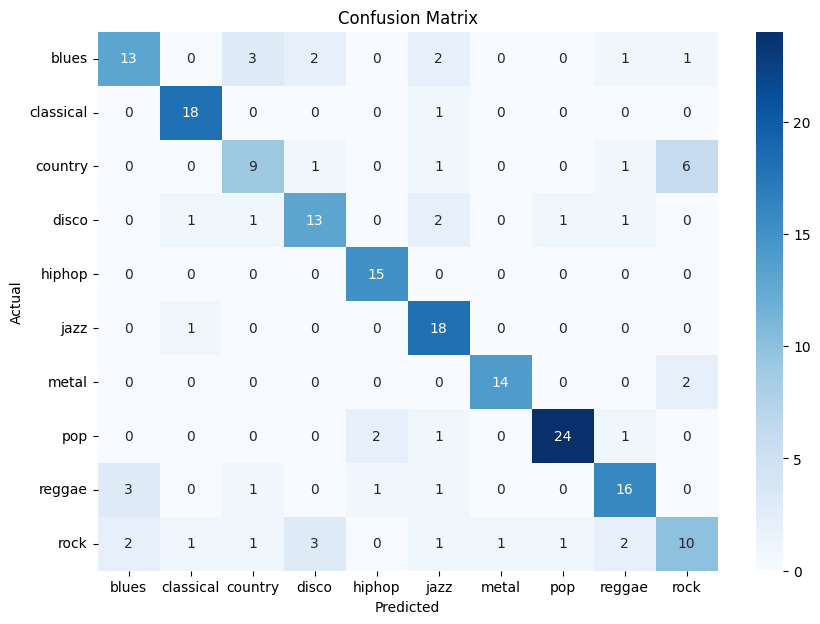

In [91]:
# Load and evaluate the best pre-trained model on the validation set
model_pretrained = models.resnet18()
num_ftrs = model_pretrained.fc.in_features
model_pretrained.fc = nn.Linear(num_ftrs, 10)
model_pretrained.load_state_dict(torch.load('Best_DL_Models/Best_Transfer_Model.pth'))
model_pretrained = model_pretrained.to(device)

model_pretrained.eval()
all_preds = []
all_labels = []

with torch.no_grad():
	for images, labels in val_loader:
		images, labels = images.to(device), labels.to(device)
		outputs = model_pretrained(images)
		_, predicted = torch.max(outputs, 1)
		all_preds.extend(predicted.cpu().numpy())
		all_labels.extend(labels.cpu().numpy())

# Generate classification report
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
